In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import csv
import numpy as np # linear algebra
import pandas as pd
from dataclasses import dataclass
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer 
from matplotlib import pyplot as plt
from nltk.corpus import stopwords

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
#Load training and validation datasets
train_df = pd.read_csv('/kaggle/input/nlp-getting-started/train.csv')
val_sentences_df = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')
val_label_df = pd.read_csv('/kaggle/input/nlp-getting-started/sample_submission.csv')

In [3]:
#Extract train sentences and labels
train_sentences, train_labels = list(train_df['text']), list(train_df['target'])
#number of training examples
len(train_sentences), len(train_labels)

(7613, 7613)

In [4]:
#no problem with this data
train_df['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [5]:
#one class validation data
val_label_df['target'].value_counts()

0    3263
Name: target, dtype: int64

In [6]:
#All of the ids in the two dataframes are the same
print(f"Length of val_sentences_df: {len(val_sentences_df['id'])} and val_label_df: {len(val_label_df['id'])}")
print("The number of different ids in two df:", sum(val_label_df['id'] != val_sentences_df['id']))

Length of val_sentences_df: 3263 and val_label_df: 3263
The number of different ids in two df: 0


In [7]:
#Val sentences and labels
val_sentences, val_labels = list(val_sentences_df['text']), list(val_label_df['target'])
#number of training examples in validation
len(val_sentences), len(val_labels)

(3263, 3263)

In [8]:
#Save all the global varibales in G class (Global)
@dataclass
class G:
    BATCH_SIZE = 32
    TRAIN_SIZE = len(train_sentences)
    VAL_SIZE = len(val_sentences)
    EPOCHS = 20 
    #at least size of training
    SHUFFLE_BUFFER_SIZE = 3300
    EMBEDDING_DIM = 100
    TRUNCATING = 'post'
    PADDING = 'post'
    OOV_TOKEN = '<OOV>'
    MAXLEN = 20 
    
    CLASS_LABELS = {1: "Disaster",
                    0 :"Normal"}

In [9]:
#Convert train and val sentences into lower case
train_sentences = [sentence.lower() for sentence in train_sentences]
val_sentences = [sentence.lower() for sentence in val_sentences]

In [10]:
#Sample sentences from train and val
train_sentences[0], val_sentences[0]

('our deeds are the reason of this #earthquake may allah forgive us all',
 'just happened a terrible car crash')

In [11]:
def remove_stopwords(sentence):
    """
    Remove stopwords from each sentence
    Args:
        sentence (string) : a row of sentence from a list
    
    Returns:
        sentence without stopwords
    """
    word_list = sentence.split(" ")
    return " ".join([word for word in word_list if word not in stopwords.words('english')])
        

In [12]:
#Remove stopwords from train and val sentences
train_sentences_without_stopwords = list(map(remove_stopwords, train_sentences))
val_sentences_without_stopwords = list(map(remove_stopwords, val_sentences))

In [13]:
#Sample sentences after remove_stopwords operation
print(train_sentences_without_stopwords[0], val_sentences_without_stopwords[0])
print(len(train_sentences_without_stopwords), len(val_sentences_without_stopwords)) 

deeds reason #earthquake may allah forgive us happened terrible car crash
7613 3263


In [14]:
train_sentence_count = np.array([len(sentence) for sentence in train_sentences_without_stopwords])
val_sentence_count = np.array([len(sentence) for sentence in val_sentences_without_stopwords])

In [15]:
print("The number of empty sentences in train:", sum(train_sentence_count == 0))
print("The number of empty sentences in val", sum(val_sentence_count == 0))
print(f"'Training' max-length sentence: {max(train_sentence_count)} and min-length sentence: {min(train_sentence_count)}")
print(f"'Validation' max-length sentence: {max(val_sentence_count)} and min-length sentence: {min(val_sentence_count)}")

The number of empty sentences in train: 0
The number of empty sentences in val 0
'Training' max-length sentence: 145 and min-length sentence: 4
'Validation' max-length sentence: 146 and min-length sentence: 4


In [16]:
def fit_tokenizer(train_sentences, oov_token):
    """
    Instantiate the tokenizer class with the given training sentences
    
    Args:
        train_sentences (list of string) : lower-cased sentences without stop words to be used for training
        oov_token (string) : symbole for out of vocabulary words
    
    Returns:
        tokenizer (object) : an instance of the Tokenizer class containing index-word dictionary
    """
    #instantiate the tokenizer object 
    tokenizer = Tokenizer(oov_token=oov_token)
    #fit the tokenizer with training sentences
    tokenizer.fit_on_texts(train_sentences)
    return tokenizer

In [17]:
tokenizer = fit_tokenizer(train_sentences_without_stopwords, G.OOV_TOKEN)
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index)

print(f"Vocabulary contains {VOCAB_SIZE} words\n")
print("<oov> included in the vocabulary" if '<OOV>' in word_index else "<OOV> not included in the vocabulary")

Vocabulary contains 22674 words

<oov> included in the vocabulary


In [18]:
def seq_pad_and_truncate(sentences, tokenizer, padding, truncating, maxlen):
    """
    Generate an array of sequences based on the tokenizer and pad them
    
    Args:
        sentences (list of string): sentences to be converted to token sequences and pad
        tokenizer (object): an instance of tokenizer object fitted on training sentences
        padding (string): type of padding to use
        truncating (string): type of truncating to use
        maxlen (int): the maximum length of each sequences
    
    Returns:
        pad_trunc_sequences (array of int): tokenized sentences padded and truncate to the same length
    """
    sequences = tokenizer.texts_to_sequences(sentences)
    pad_trunc_sequences = pad_sequences(sequences, padding=padding, truncating=truncating, maxlen=maxlen)
    return pad_trunc_sequences

In [19]:
train_pad_trunc_seq = seq_pad_and_truncate(train_sentences_without_stopwords, tokenizer, G.PADDING, G.TRUNCATING, G.MAXLEN)
val_pad_trunc_seq = seq_pad_and_truncate(val_sentences_without_stopwords, tokenizer, G.PADDING, G.TRUNCATING, G.MAXLEN)
train_labels = np.array(train_labels)
val_labels = np.array(val_labels)

In [20]:
def create_uncompiled_model():
    """
    Creates binary sentiment classifier
    
    Args:
        vocab_size (int): size of vocabulary
        embedding_dim (int): dimension of the embedding vector
        maxlen (int): length of input sequences
        embedding_matrix (array): represenation of words
    
    Returns:
        model (tf.keras.Model): sentiment classifier model
    """
    model = keras.Sequential([
        #usig pre-trained embeddings
        keras.layers.Embedding(VOCAB_SIZE+1, G.EMBEDDING_DIM, input_length=G.MAXLEN),
        keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(64, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(32)),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(32, activation='relu'),
        keras.layers.Dropout(0.2),
        keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

# **The validation set is a one class set so the evaluation is not fair way to be frank**

In [21]:
def adujst_learnig_rate_model():
    model = create_uncompiled_model()
    lr_schedule = keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(),
                  metrics=['accuracy'])
    history = model.fit(train_pad_trunc_seq, train_labels, batch_size=G.BATCH_SIZE, epochs=G.EPOCHS, callbacks=[lr_schedule])
    return history

In [22]:
lr_history = adujst_learnig_rate_model()

Epoch 1/20
238/238 [==============================] - 34s 85ms/step - loss: 0.6922 - accuracy: 0.5707 - lr: 1.0000e-06
Epoch 2/20
238/238 [==============================] - 20s 83ms/step - loss: 0.6917 - accuracy: 0.5757 - lr: 1.1220e-06
Epoch 3/20
238/238 [==============================] - 20s 82ms/step - loss: 0.6911 - accuracy: 0.5720 - lr: 1.2589e-06
Epoch 4/20
238/238 [==============================] - 20s 82ms/step - loss: 0.6905 - accuracy: 0.5713 - lr: 1.4125e-06
Epoch 5/20
238/238 [==============================] - 19s 82ms/step - loss: 0.6898 - accuracy: 0.5710 - lr: 1.5849e-06
Epoch 6/20
238/238 [==============================] - 19s 81ms/step - loss: 0.6889 - accuracy: 0.5710 - lr: 1.7783e-06
Epoch 7/20
238/238 [==============================] - 20s 86ms/step - loss: 0.6877 - accuracy: 0.5709 - lr: 1.9953e-06
Epoch 8/20
238/238 [==============================] - 20s 86ms/step - loss: 0.6858 - accuracy: 0.5702 - lr: 2.2387e-06
Epoch 9/20
238/238 [============================

(1e-06, 0.0001, 0.0, 1.0)

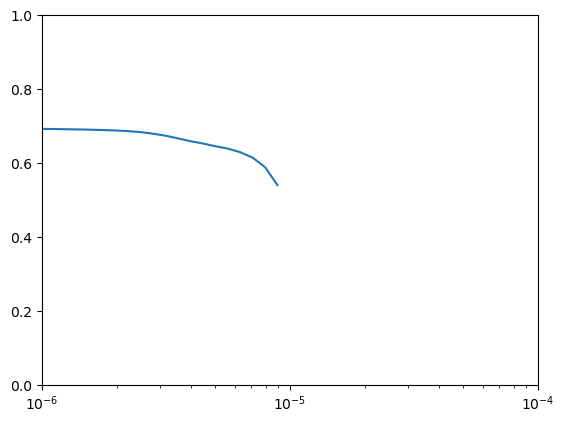

In [23]:
#Plot learning rate vs loss
plt.semilogx(lr_history.history['lr'], lr_history.history['loss'])
plt.axis(plt.axis([1e-6, 1e-4, 0, 1]))

In [24]:
def create_model():
    model = create_uncompiled_model()
    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(learning_rate=1e-5),
                  metrics=['accuracy'])
    return model

In [25]:
model = create_model()
history = model.fit(x=train_pad_trunc_seq, y=train_labels,
          batch_size=G.BATCH_SIZE, epochs=G.EPOCHS, shuffle=True)

Epoch 1/20
238/238 [==============================] - 35s 89ms/step - loss: 0.6920 - accuracy: 0.5517
Epoch 2/20
238/238 [==============================] - 21s 86ms/step - loss: 0.6863 - accuracy: 0.5706
Epoch 3/20
238/238 [==============================] - 21s 89ms/step - loss: 0.6729 - accuracy: 0.5705
Epoch 4/20
238/238 [==============================] - 20s 86ms/step - loss: 0.6559 - accuracy: 0.5814
Epoch 5/20
238/238 [==============================] - 20s 84ms/step - loss: 0.6418 - accuracy: 0.6356
Epoch 6/20
238/238 [==============================] - 20s 85ms/step - loss: 0.6255 - accuracy: 0.6893
Epoch 7/20
238/238 [==============================] - 20s 85ms/step - loss: 0.5982 - accuracy: 0.7404
Epoch 8/20
238/238 [==============================] - 20s 86ms/step - loss: 0.5366 - accuracy: 0.7935
Epoch 9/20
238/238 [==============================] - 21s 87ms/step - loss: 0.4529 - accuracy: 0.8303
Epoch 10/20
238/238 [==============================] - 20s 84ms/step - loss: 0.390

In [26]:
#ploting function 
def plot_results(epochs, train, message):
    plt.plot(epochs, train)
    plt.xlabel('Epochs')
    plt.ylabel(f"{message}")
    plt.show()

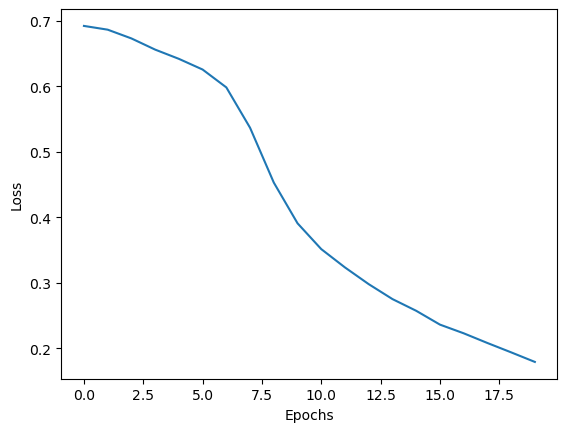

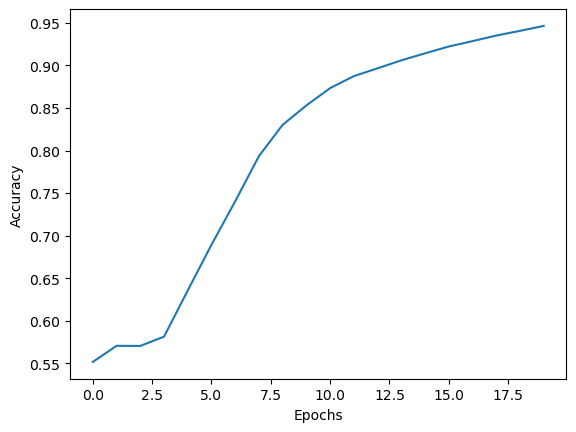

In [27]:
#Plot loss and accuracy over the specidied epochs
epochs = [*range(G.EPOCHS)]
loss = history.history['loss']
plot_results(epochs, loss, "Loss")

acc = history.history['accuracy']
plot_results(epochs, acc, "Accuracy")

In [28]:
def predict(model, val_pad_trunc_seq, batch_size):
    predictions = []
    prediction_probas = model.predict(val_pad_trunc_seq, batch_size=batch_size).squeeze()
    for prediction_proba in prediction_probas:
        if prediction_proba > 0.5:
            predictions.append(1)
        else:
            predictions.append(0)
    return np.array(predictions)

In [29]:
#Despite the val(test) set is uniclass (i.e the data contains only 0 class)
predictions = predict(model, val_pad_trunc_seq, G.BATCH_SIZE)
print("The model has predicted {} correctly out of {} examples".format(sum(predictions == val_labels), len(val_labels)))

102/102 [==============================] - 4s 17ms/step
The model has predicted 1491 correctly out of 3263 examples


In [30]:
#number of incorrectly predicted tweets
len(val_pad_trunc_seq[predictions!=val_labels])

1772

In [31]:
incorect_prediction_index = np.arange(0, len(predictions))[predictions != val_labels]

In [32]:
#sample incorrect predictions 
sample_index = 2
print(f"tweet: {tokenizer.sequences_to_texts(val_pad_trunc_seq)[incorect_prediction_index[sample_index]]}")
print(f"predicted label: {G.CLASS_LABELS[predictions[incorect_prediction_index[sample_index]]]} tweet.")
print(f"Actual label: {G.CLASS_LABELS[val_labels[incorect_prediction_index[sample_index]]]} tweet.")

print('\n\n')

sample_index = 100
print(f"tweet: {tokenizer.sequences_to_texts(val_pad_trunc_seq)[sample_index]}")
print(f"predicted label: {G.CLASS_LABELS[predictions[sample_index]]} tweet.")
print(f"Actual label: {G.CLASS_LABELS[val_labels[sample_index]]} tweet.")

tweet: typhoon soudelor kills 28 china taiwan <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
predicted label: Disaster tweet.
Actual label: Normal tweet.



tweet: brooo got annihilated https t co <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV> <OOV>
predicted label: Normal tweet.
Actual label: Normal tweet.


**Conclusion**:

The validation data has some problems with the labeling: as in the above  